# 5. multi-well scan

In [1]:
import os
import time
from useq import MDAEvent, MDASequence, Position
from pymmcore_plus.mda import mda_listeners_connected
from pymmcore_plus.mda.handlers import ImageSequenceWriter
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import numpy as np
from scipy.optimize import curve_fit
import glob
import pandas as pd
import m2stitch
from os import path

# set micro manager directory
mm_dir = 'D:\ProgramFiles\Micro-Manager-2.0'

# load micro manager system configuration
from pymmcore_plus import CMMCorePlus, Device, DeviceAdapter, ConfigGroup
core = CMMCorePlus()
#core_plus.setDeviceAdapterSearchPaths([mm_dir])
core.loadSystemConfiguration(os.path.join(mm_dir, 'MMConfig_Edge42_SOLA_ASIStage_PixelSize.cfg'))

In [2]:
# set field of view size
f = 1192.8

In [9]:
z = -1867.7

six_well_pos = [(20000, 40000, z), # A1
                (20000, 0, z), # A2
                (20000, -40000, z), # A3
                (-20000, 40000, z), # B1
                (-20000, 0, z), # B2
                (-20000, -40000, z) # B3
                ]

writer = ImageSequenceWriter(r'C:\Users\Admin\Desktop\multi_well', extension=".png", overwrite=True)

In [10]:
#core.setRelativeXYPosition(0, 80000)
time.sleep(1)

In [11]:
sequence = MDASequence(
    #axis_order = "tpgcz",
    stage_positions = [six_well_pos[0]],
    grid_plan = {'rows': 4, 'columns': 4, 
                 'relative_to': 'center',
                 'overlap': 20,
                 'mode': 'row_wise',
                 'fov_width': f,
                 'fov_height': f},
    channels = [{'group': 'LED_light', 'config': 'on'}]
)

2024-08-14 18:07:05,347 - pymmcore-plus - INFO - (_runner.py:321) MDA Started: stage_positions=(Position(x=20000.0, y=40000.0, z=-1867.7, name=None, sequence=None),) grid_plan=GridRowsColumns(fov_width=1192.7552, fov_height=1192.7552, overlap=(20.0, 20.0), mode=<OrderMode.row_wise: 'row_wise'>, rows=4, columns=4, relative_to=<RelativeTo.center: 'center'>) channels=(Channel(config='on', group='LED_light', exposure=None, do_stack=True, z_offset=0.0, acquire_every=1, camera=None),)
2024-08-14 18:07:05,349 - pymmcore-plus - INFO - (_runner.py:283) index=mappingproxy({'p': 0, 'g': 0, 'c': 0}) channel=Channel(config='on', group='LED_light') x_pos=18568.693760000002 y_pos=41431.30624 z_pos=-1867.7
2024-08-14 18:07:07,682 - pymmcore-plus - INFO - (_runner.py:283) index=mappingproxy({'p': 0, 'g': 1, 'c': 0}) channel=Channel(config='on', group='LED_light') x_pos=19522.89792 y_pos=41431.30624 z_pos=-1867.7
2024-08-14 18:07:08,462 - pymmcore-plus - INFO - (_runner.py:283) index=mappingproxy({'p': 

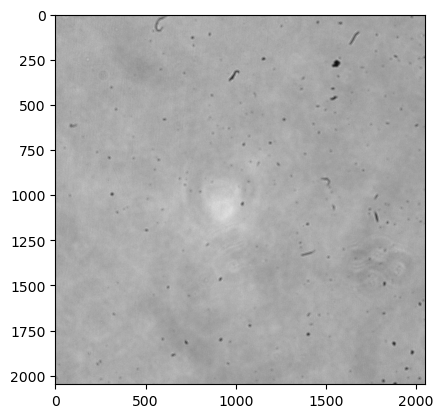

In [12]:
with mda_listeners_connected(writer):
    core.mda.run(sequence)
    
core.snapImage()
im = core.getImage()

core.setConfig('LED_light', 'off')

plt.imshow(im, cmap='gray')

In [13]:
cross_images = glob.glob(r'C:\Users\Admin\Desktop\multi_well\*.png')
len(cross_images)

16

In [14]:
images = np.stack([cv2.imread(file) for file in cross_images],
                  axis=0)
images_squeezed = images[:, :, :, 1]
images_squeezed.shape

(16, 2048, 2048)

In [15]:
grid_size = 4

def flatten_rows(rows):
    r = []
    for xs in rows:
        for x in xs:
            r.append(x)
    return r

def flatten_cols(cols):
    c = np.concatenate(cols).ravel().tolist()
    return c

rows = []
cols = []
for r in range(grid_size):
    rows.append([r+1]*(grid_size))
    cols.append([np.arange(1, grid_size+1)])

c = flatten_cols(cols)
r = flatten_rows(rows)

In [16]:
result_df, _ = m2stitch.stitch_images(
    images_squeezed, r, c, 
    row_col_transpose=False,
    ncc_threshold=0.0001
)

100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


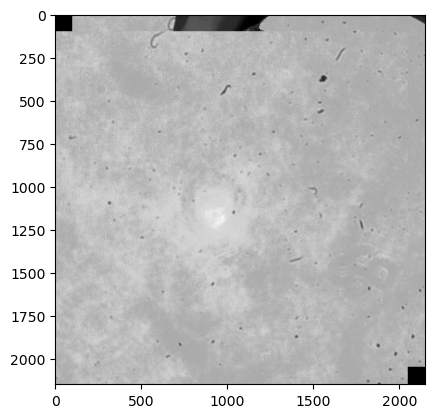

In [17]:
images = images_squeezed

# stitching example
result_df["y_pos2"] = result_df["y_pos"] - result_df["y_pos"].min()
result_df["x_pos2"] = result_df["x_pos"] - result_df["x_pos"].min()

size_y = images.shape[1]
size_x = images.shape[2]

stitched_image_size = (
    result_df["y_pos2"].max() + size_y,
    result_df["x_pos2"].max() + size_x,
)
stitched_image = np.zeros_like(images, shape=stitched_image_size)
for i, row in result_df.iterrows():
    stitched_image[
        row["y_pos2"] : row["y_pos2"] + size_y,
        row["x_pos2"] : row["x_pos2"] + size_x,
    ] = images[i]
    
plt.imshow(stitched_image, cmap='grey')